In [2]:
import torch
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

Exécution sur cuda:0


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

from torchvision.transforms import ToTensor, ToPILImage

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


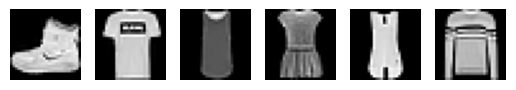

In [5]:
n_images = 5

fig = plt.figure()
for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images+1, i+1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images:
        break
plt.show()

In [6]:
class VariationalAutoEncoder(nn.Module):  # <-- même nom que l'instance
    def __init__(self, latent_dim):
        super().__init__()

        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)   # 28 -> 14
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 14 -> 7
        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 7 -> 14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)   # 14 -> 28

    def latent_sample(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        # Encode
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = self.flatten(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.latent_sample(mu, logvar)

        # Decode
        h = F.relu(self.dec_fc(z))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_hat = torch.sigmoid(self.dec_deconv2(h))

        # IMPORTANT: on renvoie bien 4 sorties comme ton train() l'attend
        return x_hat, z, mu, logvar

**Model 2**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim, base_channels=32):
        super().__init__()
        c1 = base_channels
        c2 = base_channels * 2  # double

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, c1, kernel_size=4, stride=2, padding=1)   # 28 -> 14
        self.enc_conv2 = nn.Conv2d(c1, c2, kernel_size=4, stride=2, padding=1)  # 14 -> 7
        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(c2 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(c2 * 7 * 7, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, c2 * 7 * 7)
        self.dec_deconv1 = nn.ConvTranspose2d(c2, c1, kernel_size=4, stride=2, padding=1)  # 7 -> 14
        self.dec_deconv2 = nn.ConvTranspose2d(c1, 1, kernel_size=4, stride=2, padding=1)   # 14 -> 28

    def latent_sample(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x):
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))
        h = self.flatten(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.latent_sample(mu, logvar)

        h = F.relu(self.dec_fc(z))
        # récupère c2 automatiquement depuis la couche
        c2 = self.dec_deconv1.in_channels
        h = h.view(-1, c2, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_hat = torch.sigmoid(self.dec_deconv2(h))
        return x_hat, z, mu, logvar


In [8]:
vae_small = VariationalAutoEncoder(latent_dim=20, base_channels=16)
vae_large = VariationalAutoEncoder(latent_dim=20, base_channels=64)
vae_base  = VariationalAutoEncoder(latent_dim=20, base_channels=32)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [10]:
@torch.no_grad()
def evaluate(model, loader, beta=0.3, device="cuda"):
    model.eval()
    total, total_recon, total_kl = 0.0, 0.0, 0.0
    n = 0
    for x, _ in loader:
        x = x.to(device)
        x_hat, z, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x_hat, x, mu, logvar, beta=beta)
        bs = x.size(0)
        total += loss.item() * bs
        total_recon += recon.item() * bs
        total_kl += kl.item() * bs
        n += bs
    return total / n, total_recon / n, total_kl / n


def train(model, train_loader, test_loader, epochs=10, lr=1e-3, beta=1.0, grad_clip=1.0, device="cuda"):
    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, running_recon, running_kl = 0.0, 0.0, 0.0
        n = 0

        for x, _ in train_loader:
            x = x.to(device)

            x_hat, z, mu, logvar = model(x)
            loss, recon, kl = vae_loss(x_hat, x, mu, logvar, beta=beta)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()

            bs = x.size(0)
            running_loss += loss.item() * bs
            running_recon += recon.item() * bs
            running_kl += kl.item() * bs
            n += bs

        train_loss = running_loss / n
        train_recon = running_recon / n
        train_kl = running_kl / n

        test_loss, test_recon, test_kl = evaluate(model, test_loader, beta=beta, device=device)

        print(
            f"Epoch {epoch:02d} | "
            f"train loss {train_loss:.4f} (recon {train_recon:.4f}, kl {train_kl:.4f}) | "
            f"test loss {test_loss:.4f} (recon {test_recon:.4f}, kl {test_kl:.4f})"
        )

    return model

In [11]:
def vae_loss(x_hat, x, mu, logvar, beta=0.3):
    recon = F.binary_cross_entropy(x_hat, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon + beta * kl, recon, kl


In [12]:
latent_dim = 20
#vae = VariationalAutoEncoder(latent_dim)

vae = train(
    vae_base,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=30,
    lr=1e-3,
    beta=0.3,
   
    device=device
)

Epoch 01 | train loss 268.4374 (recon 258.5125, kl 33.0830) | test loss 238.5026 (recon 228.0928, kl 34.6995)
Epoch 02 | train loss 235.5031 (recon 225.2698, kl 34.1109) | test loss 231.6883 (recon 221.3494, kl 34.4632)
Epoch 03 | train loss 231.3154 (recon 221.0735, kl 34.1396) | test loss 228.6497 (recon 218.6768, kl 33.2430)
Epoch 04 | train loss 229.0249 (recon 218.7597, kl 34.2174) | test loss 227.0872 (recon 216.9362, kl 33.8365)
Epoch 05 | train loss 227.5345 (recon 217.2866, kl 34.1597) | test loss 225.8443 (recon 215.6549, kl 33.9648)
Epoch 06 | train loss 226.5839 (recon 216.3322, kl 34.1723) | test loss 224.7841 (recon 214.7381, kl 33.4868)
Epoch 07 | train loss 225.9194 (recon 215.6583, kl 34.2036) | test loss 224.5587 (recon 214.4759, kl 33.6092)
Epoch 08 | train loss 225.3680 (recon 215.1413, kl 34.0890) | test loss 224.3198 (recon 213.9583, kl 34.5385)
Epoch 09 | train loss 224.9878 (recon 214.7571, kl 34.1022) | test loss 224.1859 (recon 213.9586, kl 34.0911)
Epoch 10 |

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

@torch.no_grad()
def build_latent_dataset(vae, loader, device, use_mu=True):
    vae.eval()
    zs = []
    for x, _ in loader:
        x = x.to(device)
        x_hat, z, mu, logvar = vae(x)
        zs.append(mu.detach().cpu() if use_mu else z.detach().cpu())
    Z = torch.cat(zs, dim=0)  # (N, latent_dim)
    return TensorDataset(Z)

# Geler le VAE (on ne l'entraîne plus)
for p in vae.parameters():
    p.requires_grad = False
vae = vae.to(device).eval()

latent_train_ds = build_latent_dataset(vae, train_loader, device=device, use_mu=True)
latent_test_ds  = build_latent_dataset(vae, test_loader, device=device, use_mu=True)

latent_train_loader = DataLoader(latent_train_ds, batch_size=512, shuffle=True)
latent_test_loader  = DataLoader(latent_test_ds, batch_size=1024, shuffle=False)

print("Latent dataset shape:", next(iter(latent_train_loader))[0].shape)


Latent dataset shape: torch.Size([512, 20])


In [14]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device).float() / (half - 1)
        )
        args = t * freqs[None, :] * 2 * math.pi
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb


class FlowMatchingMLP(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, time_emb_dim=64, depth=2, dropout=0.0):
        """
        depth = nombre de couches cachées (Linear+ReLU) après la 1ère projection.
        Ex:
          depth=1 -> (in -> hidden) + (hidden -> out)
          depth=2 -> (in -> hidden) + (hidden -> hidden) + (hidden -> out)  (ton modèle actuel)
          depth=4 -> plus profond
        """
        super().__init__()
        self.t_emb = SinusoidalTimeEmbedding(time_emb_dim)

        layers = []
        in_dim = latent_dim + time_emb_dim

        # 1ère couche
        layers += [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        if dropout > 0:
            layers += [nn.Dropout(dropout)]

        # couches cachées supplémentaires
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
            if dropout > 0:
                layers += [nn.Dropout(dropout)]

        # sortie: vitesse de dimension latent_dim
        layers += [nn.Linear(hidden_dim, latent_dim)]

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        te = self.t_emb(t)
        inp = torch.cat([z, te], dim=1)
        return self.net(inp)


In [15]:
def fm_loss(v_pred, v_target):
    return F.mse_loss(v_pred, v_target)

@torch.no_grad()
def evaluate_fm(fm, loader, device):
    fm.eval()
    total = 0.0
    n = 0
    for (z1,) in loader:
        z1 = z1.to(device)
        b, d = z1.shape
        z0 = torch.randn_like(z1)

        t = torch.rand(b, 1, device=device)
        zt = (1 - t) * z0 + t * z1
        v_target = z1 - z0

        v_pred = fm(zt, t)
        loss = fm_loss(v_pred, v_target)

        total += loss.item() * b
        n += b
    return total / n

def train_fm(fm, train_loader, test_loader, device, epochs=50, lr=2e-4):
    fm = fm.to(device)
    opt = torch.optim.AdamW(fm.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        fm.train()
        running = 0.0
        n = 0

        for (z1,) in train_loader:
            z1 = z1.to(device)
            b, d = z1.shape

            z0 = torch.randn_like(z1)
            t = torch.rand(b, 1, device=device)

            zt = (1 - t) * z0 + t * z1
            v_target = z1 - z0

            v_pred = fm(zt, t)
            loss = fm_loss(v_pred, v_target)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item() * b
            n += b

        train_loss = running / n
        test_loss = evaluate_fm(fm, test_loader, device)

        print(f"FM Epoch {epoch:03d} | train {train_loss:.6f} | test {test_loss:.6f}")

    return fm


In [16]:
fm_small = FlowMatchingMLP(latent_dim=latent_dim, hidden_dim=128, time_emb_dim=32, depth=2)
fm_base  = FlowMatchingMLP(latent_dim=latent_dim, hidden_dim=256, time_emb_dim=64, depth=2)
fm_large = FlowMatchingMLP(latent_dim=latent_dim, hidden_dim=512, time_emb_dim=128, depth=3)

In [17]:
fm_depth2 = FlowMatchingMLP(latent_dim=latent_dim, hidden_dim=256, time_emb_dim=64, depth=2)
fm_depth4 = FlowMatchingMLP(latent_dim=latent_dim, hidden_dim=256, time_emb_dim=64, depth=4)


In [26]:
latent_dim = 20  

fm = train_fm(
    fm_small,
    train_loader=latent_train_loader,
    test_loader=latent_test_loader,
    device=device,
    epochs=50,
    lr=2e-4
)


FM Epoch 001 | train 1.918763 | test 1.893698
FM Epoch 002 | train 1.843658 | test 1.784653
FM Epoch 003 | train 1.734925 | test 1.683483
FM Epoch 004 | train 1.648532 | test 1.600744
FM Epoch 005 | train 1.585197 | test 1.559519
FM Epoch 006 | train 1.550920 | test 1.532383
FM Epoch 007 | train 1.523695 | test 1.506354
FM Epoch 008 | train 1.506332 | test 1.496904
FM Epoch 009 | train 1.497054 | test 1.482369
FM Epoch 010 | train 1.489700 | test 1.476508
FM Epoch 011 | train 1.481390 | test 1.473730
FM Epoch 012 | train 1.480503 | test 1.472919
FM Epoch 013 | train 1.472275 | test 1.463162
FM Epoch 014 | train 1.471813 | test 1.460585
FM Epoch 015 | train 1.464960 | test 1.456323
FM Epoch 016 | train 1.461794 | test 1.438002
FM Epoch 017 | train 1.457498 | test 1.453721
FM Epoch 018 | train 1.456205 | test 1.448797
FM Epoch 019 | train 1.453966 | test 1.444268
FM Epoch 020 | train 1.450560 | test 1.450085
FM Epoch 021 | train 1.449377 | test 1.440081
FM Epoch 022 | train 1.450163 | te

In [27]:
@torch.no_grad()
def sample_fm_latents(fm, n_samples, latent_dim, device, n_steps=50):
    fm.eval()
    z = torch.randn(n_samples, latent_dim, device=device)  # z0 ~ N(0,I)
    dt = 1.0 / n_steps

    for k in range(n_steps):
        t = torch.full((n_samples, 1), k / n_steps, device=device)
        v = fm(z, t)
        z = z + dt * v  # Euler step

    return z


In [28]:
@torch.no_grad()
def decode_latents(vae, z, device):
    vae.eval()
    z = z.to(device)

    h = F.relu(vae.dec_fc(z))

    # c2 = nombre de canaux attendus par dec_deconv1
    c2 = vae.dec_deconv1.in_channels  # ex: 32 si base_channels=16, 64 si base_channels=32, etc.
    h = h.view(-1, c2, 7, 7)

    h = F.relu(vae.dec_deconv1(h))
    x_hat = torch.sigmoid(vae.dec_deconv2(h))
    return x_hat


In [29]:
@torch.no_grad()
def sample_baseline_latents(n_samples, latent_dim, device):
    return torch.randn(n_samples, latent_dim, device=device)

n = 64
z_base = sample_baseline_latents(n, latent_dim, device)
x_base = decode_latents(vae, z_base, device)

z_fm = sample_fm_latents(fm, n, latent_dim, device, n_steps=50)
x_fm = decode_latents(vae, z_fm, device)


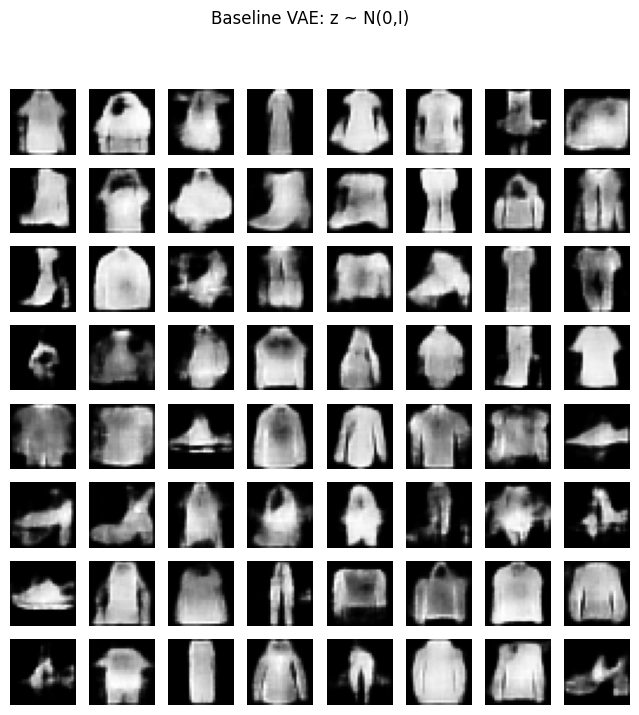

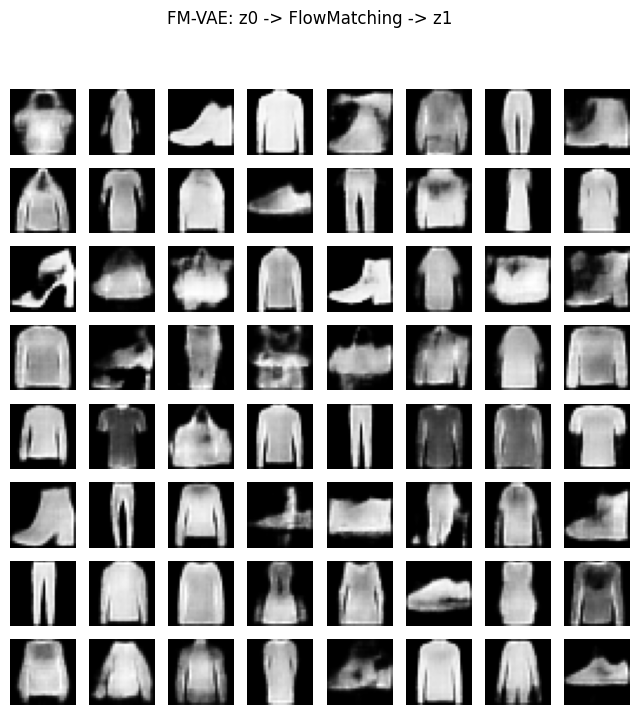

In [30]:
import matplotlib.pyplot as plt

def show_grid(images, title="", nrow=8):
    images = images.detach().cpu().numpy()
    fig, axes = plt.subplots(nrow, nrow, figsize=(8,8))
    fig.suptitle(title)
    idx = 0
    for i in range(nrow):
        for j in range(nrow):
            axes[i,j].imshow(images[idx,0], cmap="gray")
            axes[i,j].axis("off")
            idx += 1
    plt.show()

show_grid(x_base, "Baseline VAE: z ~ N(0,I)")
show_grid(x_fm, "FM-VAE: z0 -> FlowMatching -> z1")


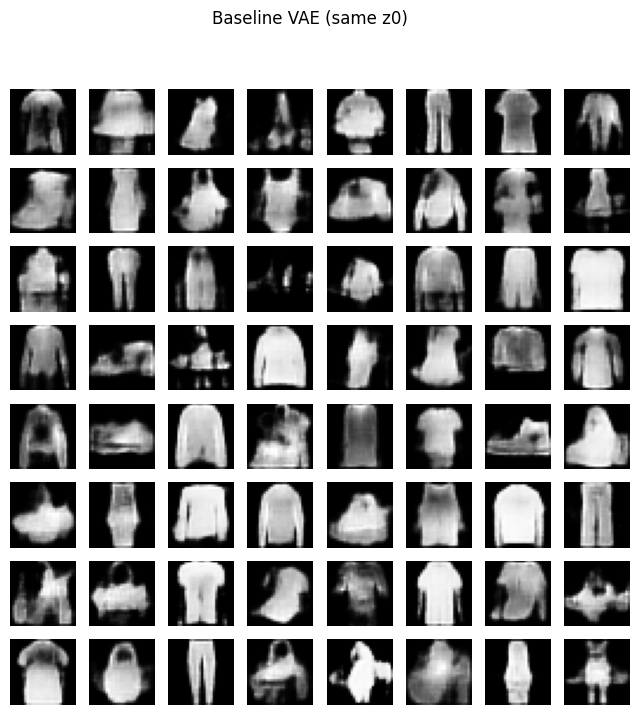

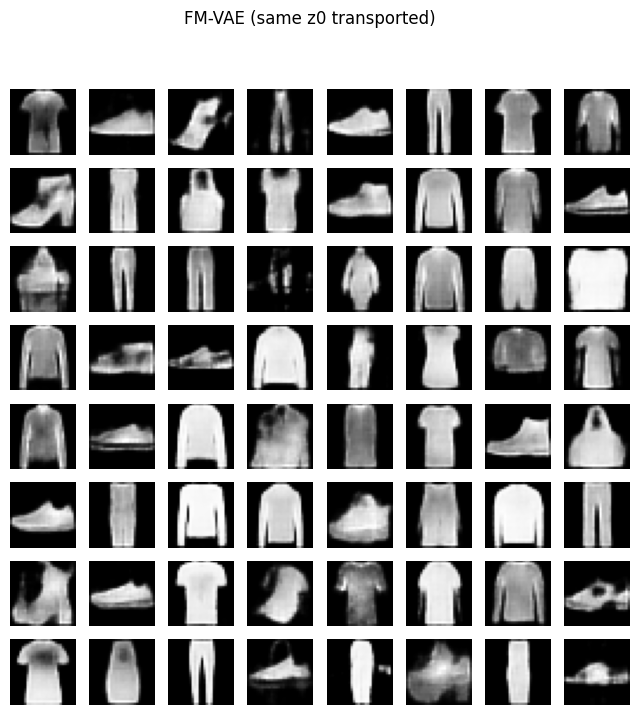

In [118]:
n = 64
z0 = sample_baseline_latents(n, latent_dim, device)

x_base = decode_latents(vae, z0, device)

z_fm = z0.clone()
dt = 1.0 / 50
for k in range(50):
    t = torch.full((n, 1), k / 50, device=device)
    z_fm = z_fm + dt * fm(z_fm, t)

x_fm = decode_latents(vae, z_fm, device)

show_grid(x_base, "Baseline VAE (same z0)")
show_grid(x_fm, "FM-VAE (same z0 transported)")


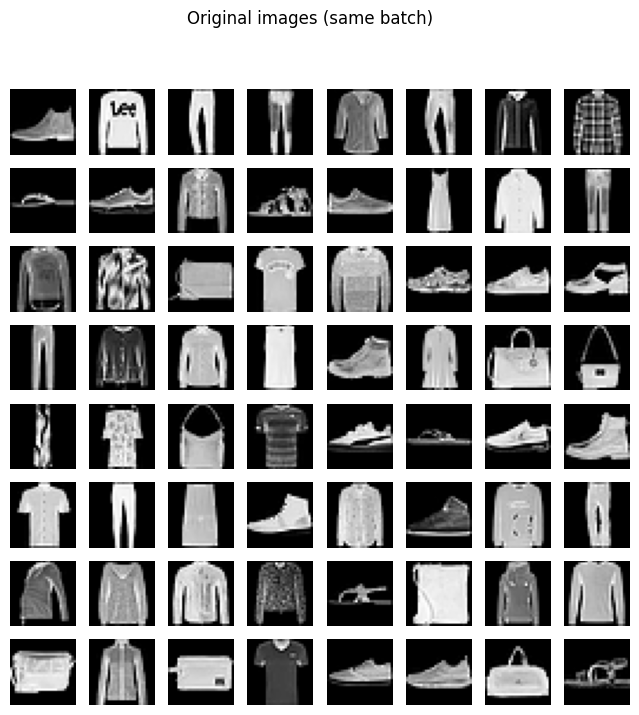

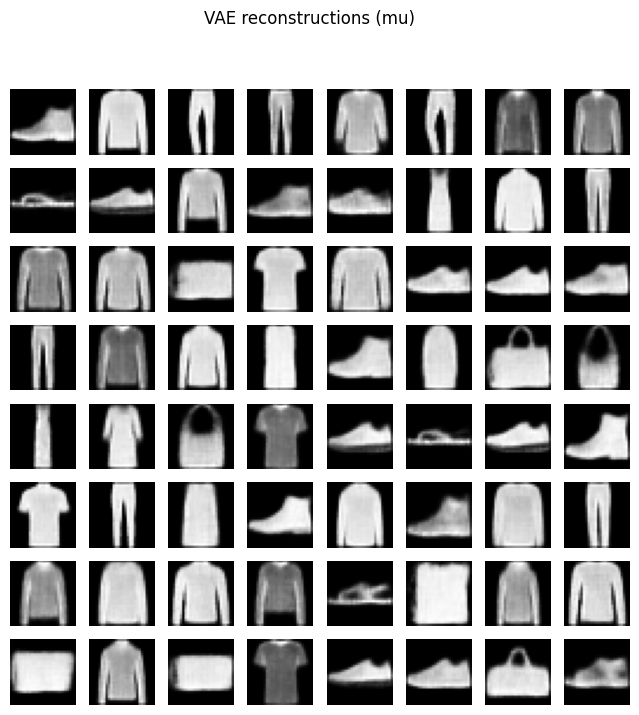

In [96]:
@torch.no_grad()
def reconstruct_batch(vae, loader, device, use_mu=True):
    vae.eval()
    x, y = next(iter(loader))
    x = x.to(device)
    x_hat, z, mu, logvar = vae(x)
    z_used = mu if use_mu else z
    # si tu veux forcer la reconstruction via decode_latents:
    x_rec = decode_latents(vae, z_used, device)
    return x, x_rec

x, x_rec = reconstruct_batch(vae, test_loader, device, use_mu=True)
show_grid(x[:64], "Original images (same batch)")
show_grid(x_rec[:64], "VAE reconstructions (mu)")


In [68]:
import torch
import numpy as np

@torch.no_grad()
def collect_latents_mu(vae, loader, device, max_batches=None):
    vae.eval()
    Z, Y = [], []
    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break
        x = x.to(device)
        _, _, mu, _ = vae(x)   # ton forward renvoie x_hat, z, mu, logvar
        Z.append(mu.detach().cpu().numpy())
        Y.append(y.numpy())
    Z = np.concatenate(Z, axis=0)
    Y = np.concatenate(Y, axis=0)
    return Z, Y


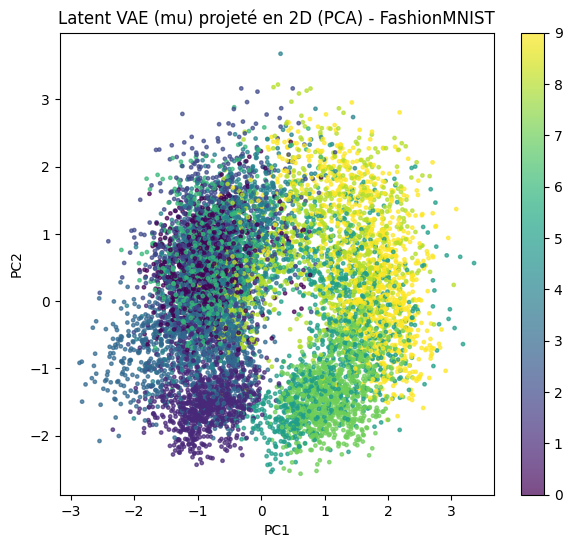

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Z, Y = collect_latents_mu(vae, test_loader, device)  # Z shape (N, 20)

Z2 = PCA(n_components=2).fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], c=Y, s=6, alpha=0.7)
plt.colorbar()
plt.title("Latent VAE (mu) projeté en 2D (PCA) - FashionMNIST")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


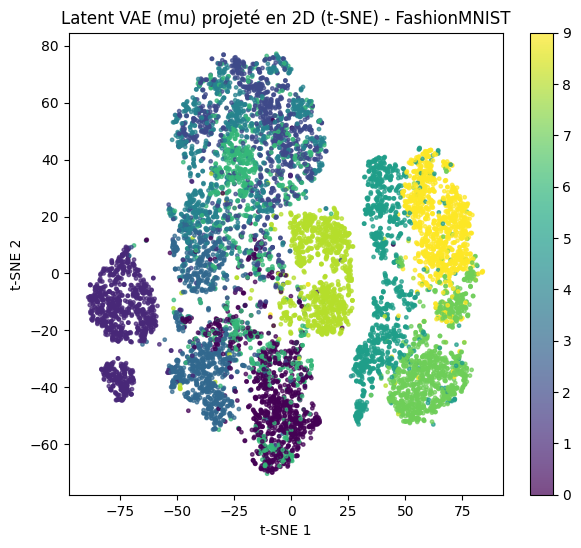

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Z, Y = collect_latents_mu(vae, test_loader, device, max_batches=40)  # limite pour aller vite

Z2 = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto").fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(Z2[:,0], Z2[:,1], c=Y, s=6, alpha=0.7)
plt.colorbar()
plt.title("Latent VAE (mu) projeté en 2D (t-SNE) - FashionMNIST")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()
